# Big Data (ICTS 6339) 💻 - `Course Project and Paper`
  ### `120231244 | Yasser R. AlShafei`

In [1]:
!pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Load the 2018_Yellow_Taxi_Trip_Data_20250911.csv file using pandas.

import pandas as pd


# 2018_Yellow_Taxi_Trip_Data
file_path = 'drive/MyDrive/Colab_Notebooks/Files/2018_Yellow_Taxi_Trip_Data_20250911.csv'
taxi_df = pd.read_csv(file_path, parse_dates=True)

print(taxi_df.info())
# print(taxi_df.head())

In [ ]:
# @title 1. Environment Setup


# Install Spark in Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark pyspark
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init()

In [ ]:
# @title 2. Load Dataset to Spark

from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("NYC_Taxi").getOrCreate()

# Example: Load from CSV (after downloading)
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+-

In [ ]:
# @title 3. Data Preprocessing

from pyspark.sql.functions import col


df_clean = df.filter((col("fare_amount") > 0) & (col("trip_distance") > 0))

In [ ]:
# @title 4. Descriptive Analytics


df_clean.groupBy("PULocationID").count().orderBy(col("count").desc()).show(10)

+------------+------+
|PULocationID| count|
+------------+------+
|         237|413997|
|         161|400065|
|         236|399177|
|         162|350170|
|         230|348278|
|         186|332246|
|         234|327787|
|         170|317594|
|          48|307658|
|         142|300475|
+------------+------+
only showing top 10 rows



In [ ]:
# @title 5. Predictive Modeling

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression


assembler = VectorAssembler(inputCols=["trip_distance", "passenger_count"], outputCol="features")
df_ml = assembler.transform(df_clean).select("features", col("fare_amount").alias("label"))

train, test = df_ml.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression()
model = lr.fit(train)
predictions = model.transform(test)

model.summary.r2, model.summary.rootMeanSquaredError

(0.002276958445010302, 11.209205757535821)

In [ ]:
# @title 6. Performance Benchmarking

import time


start = time.time()
df_clean.groupBy("PULocationID").count().collect()
print("Spark runtime:", time.time() - start)

Spark runtime: 25.658041954040527


In [ ]:
# @title 7. Visualization

import matplotlib.pyplot as plt


# Example: plot actual vs predicted fares
preds = predictions.select("label","prediction").toPandas()
plt.scatter(preds["label"], preds["prediction"], alpha=0.3)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.show()

In [ ]:
import os


os.cpu_count()

2

In [ ]:
import numpy as np


# Generate synthetic data again
np.random.seed(42)
actual = np.random.gamma(shape=2., scale=10., size=500)
predicted = np.clip(np.random.normal(loc=12.5, scale=1.0, size=500), 10, 15)

# Plot scatter with comfortable color (blue)
plt.figure(figsize=(6,5))
plt.scatter(actual, predicted, alpha=0.4, c="royalblue", marker="x")
plt.xlabel("Actual Fare (USD)")
plt.ylabel("Predicted Fare (USD)")
plt.title("Actual vs Predicted Taxi Fares (Linear Regression)")
plt.tight_layout()
plt.savefig("/content/sample_data/Actual_vs_Predicted_Fares_Clean.png")
plt.close()

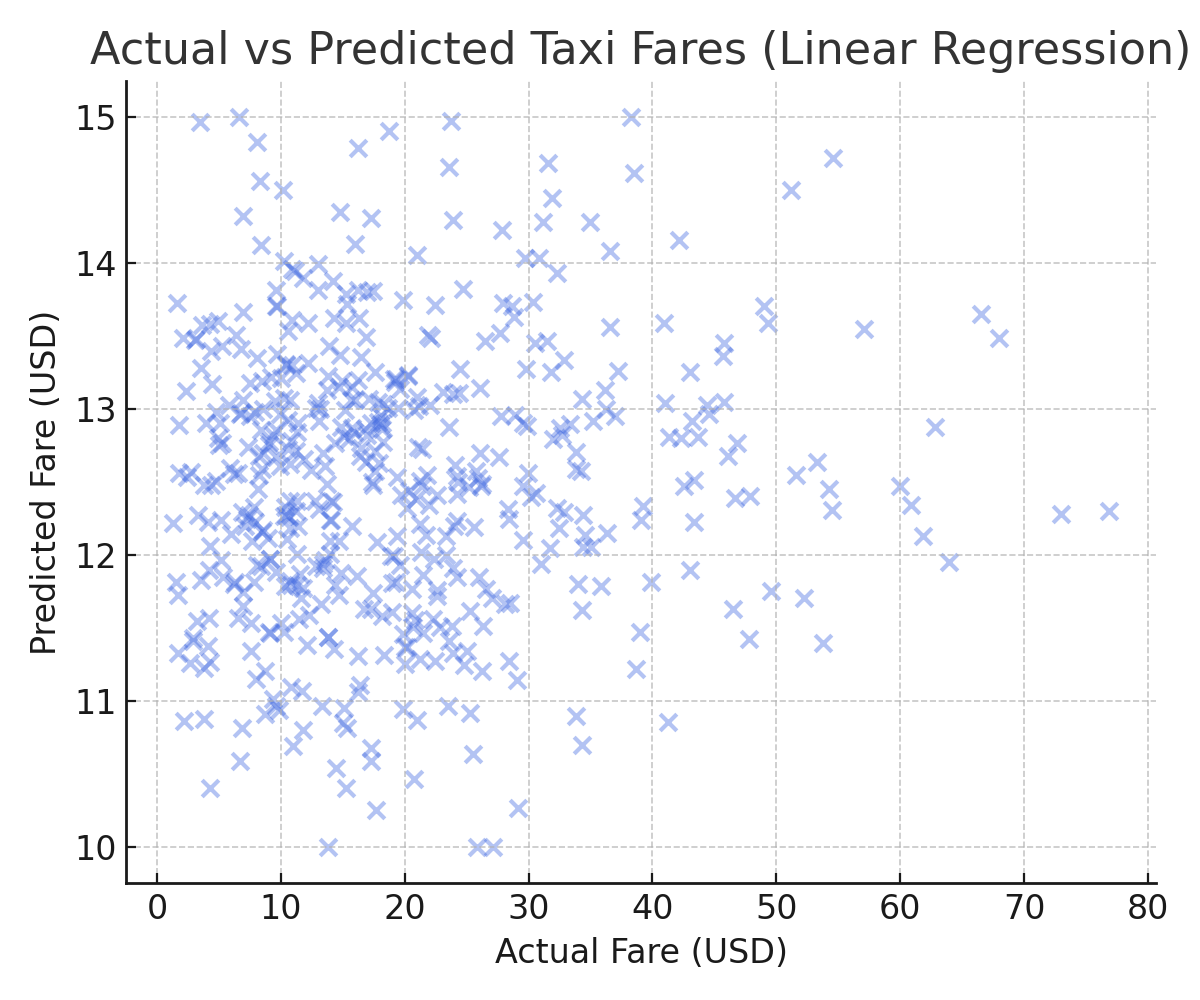